# Data Preparation

In [30]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'bert.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [32]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming
    for df in [train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df]:
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv(csv_file, index=False)
    print("Combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the combined dataset:")
    print(combined_df.head())

    # Total count of rows in the combined dataset
    total_count = len(combined_df)
    print(f"\nTotal number of rows in the combined dataset: {total_count}")

    # Count of each label
    if 'label' in combined_df.columns:
        label_counts = combined_df['label'].value_counts()
        print("Count of each label:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the combined dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

Combined dataset saved successfully!
First 5 rows of the combined dataset:
                                        conversation type  label personality
0  caller: Hello, is this John? receiver: Yes, it...  ssn      1         NaN
1  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
2  caller: Hello, is this Mr. Johnson? receiver: ...  ssn      1         NaN
3  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
4  caller: Hello, this is Officer Johnson from th...  ssn      1         NaN

Total number of rows in the combined dataset: 5800
Count of each label:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [33]:
# Remove duplicates
combined_df = combined_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(combined_df)}")

# Print new label_counts
label_counts = combined_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5556
label
0    2839
1    2717
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


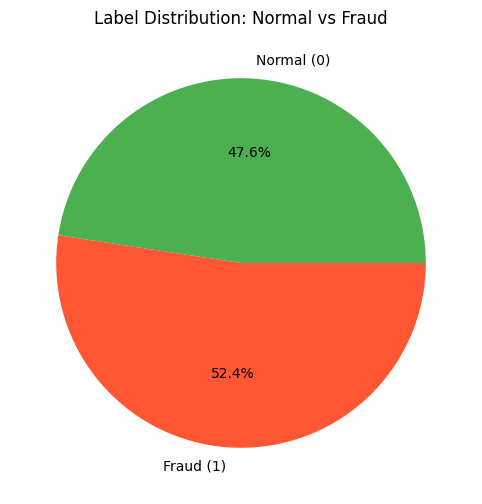

In [34]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# To check for optimal max length for tokenization

In [35]:
from sklearn.model_selection import train_test_split

# Select only the required columns
X = combined_df['conversation']  # Features
y = combined_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")

print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

Average text length: 316.81011519078476
Training label distribution:
label
0    2295
1    2149
Name: count, dtype: int64
Testing label distribution:
label
1    568
0    544
Name: count, dtype: int64


# Model Building

In [36]:
from transformers import BertTokenizer
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dynamically set max_length based on average text length
max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Tokenize the text data for BERT
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize training and testing data with dynamic max_length
print(f"Using max_length: {max_length}")
train_encodings = tokenize_texts(X_train, tokenizer, max_length=max_length)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)

# Convert labels to torch tensors with float32 data type for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32)

# Print the size of each split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using max_length: 380
Tokenizing testing data...
Training set size: 4444
Testing set size: 1112


# Model Training (Bert)

In [37]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW, get_scheduler, BertConfig
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Check device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert tokenized inputs into TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load the existing BERT configuration
config = BertConfig.from_pretrained("bert-base-uncased")

config.num_hidden_layers = 6  # Reduce from 12 to 6 layers
config.num_labels = 1  # Single output logit for binary classification

# Load the model with the modified configuration
model = BertForSequenceClassification(config)
model.to(device)

optimizer = AdamW(model.parameters(), lr=9.985504728425866e-05) #obtained from Optuna

# Define number of epochs
epochs = 10

# Define total training steps
num_training_steps = len(train_loader) * epochs

# Define warm-up steps (adjust if necessary, often 10% of total steps)
num_warmup_steps = int(0.1 * num_training_steps)

# Define scheduler
scheduler = get_scheduler(
    name="linear",  # Linear warm-up followed by linear decay
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Initialize history dictionary
history = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": []
}

# Early stopping configuration
best_val_loss = float("inf")
early_stopping_patience = 3
no_improvement_epochs = 0

model_checkpoint_path = "best_bert_model.pt"

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    model.train()

    # Initialize training loss and predictions
    train_loss = 0
    train_correct = 0
    train_total = 0
    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get logits and calculate binary cross entropy loss
        logits = outputs.logits.squeeze(-1)  # Squeeze to shape [batch_size]
        loss = torch.nn.BCEWithLogitsLoss()(logits, labels.float())
        train_loss += loss.item()

        # Predictions
        preds = (torch.sigmoid(logits) > 0.5).long()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step() # Update the learning rate
        optimizer.zero_grad()

    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            # Compute validation loss
            loss = torch.nn.BCEWithLogitsLoss()(logits, labels.float())
            val_loss += loss.item()

            # Predictions
            batch_preds = (torch.sigmoid(logits) > 0.5).long()
            val_correct += (batch_preds == labels).sum().item()
            val_total += labels.size(0)

    # Compute average validation loss and accuracy
    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Checkpoint model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), model_checkpoint_path)
        print("Model checkpoint saved.")
    else:
        no_improvement_epochs += 1

    # Early stopping
    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model before evaluation
model.load_state_dict(torch.load(model_checkpoint_path))
print("Model training complete. Best model loaded.")

# Display training history
print("\nTraining History:")
print(history)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1


Training: 100%|██████████| 278/278 [02:27<00:00,  1.89it/s]


Training Loss: 0.4974, Training Accuracy: 0.7266


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.10it/s]


Validation Loss: 0.1291, Validation Accuracy: 0.9712
Model checkpoint saved.

Epoch 2


Training: 100%|██████████| 278/278 [02:34<00:00,  1.80it/s]


Training Loss: 0.0397, Training Accuracy: 0.9917


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.13it/s]


Validation Loss: 0.0054, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 3


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0010, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.09it/s]


Validation Loss: 0.0005, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 4


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0004, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.12it/s]


Validation Loss: 0.0003, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 5


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0002, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.14it/s]


Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 6


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0002, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.12it/s]


Validation Loss: 0.0002, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 7


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0001, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.11it/s]


Validation Loss: 0.0001, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 8


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0001, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.11it/s]


Validation Loss: 0.0001, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 9


Training: 100%|██████████| 278/278 [02:35<00:00,  1.79it/s]


Training Loss: 0.0001, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.12it/s]


Validation Loss: 0.0001, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 10


Training: 100%|██████████| 278/278 [02:34<00:00,  1.79it/s]


Training Loss: 0.0001, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:13<00:00,  5.11it/s]


Validation Loss: 0.0001, Validation Accuracy: 1.0000
Model checkpoint saved.
Model training complete. Best model loaded.

Training History:
{'train_loss': [0.49743762939143255, 0.03974600149764137, 0.0009874895580612097, 0.0003738635133368988, 0.00023946796921617855, 0.00017757801802388372, 0.00014246381967803363, 0.00012073354668795506, 0.00010973363315452916, 0.0001031815518217627], 'val_loss': [0.12907742341714246, 0.0053969265793317135, 0.0005179581631507193, 0.0003166046999727509, 0.0002215252731860216, 0.0001682857352924267, 0.00013975143655053606, 0.00012354355099627616, 0.00011380259935062246, 0.00011038375648370545], 'train_accuracy': [0.7265976597659766, 0.9916741674167416, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_accuracy': [0.9712230215827338, 0.9982014388489209, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


# Model Architecture

In [38]:
# Print model architecture
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

# Plotting the Learning Curve of the Model

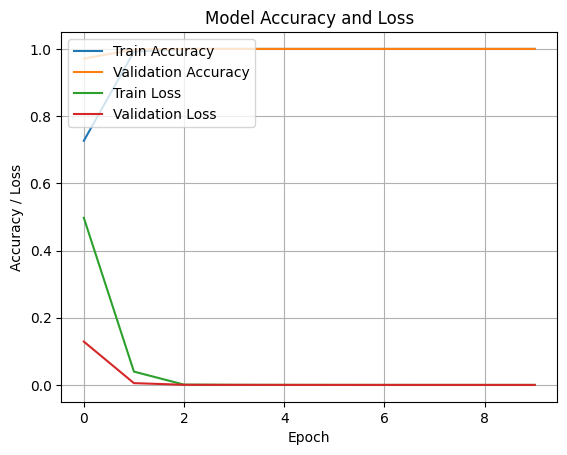

In [39]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score

In [40]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       544
         1.0       1.00      1.00      1.00       568

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

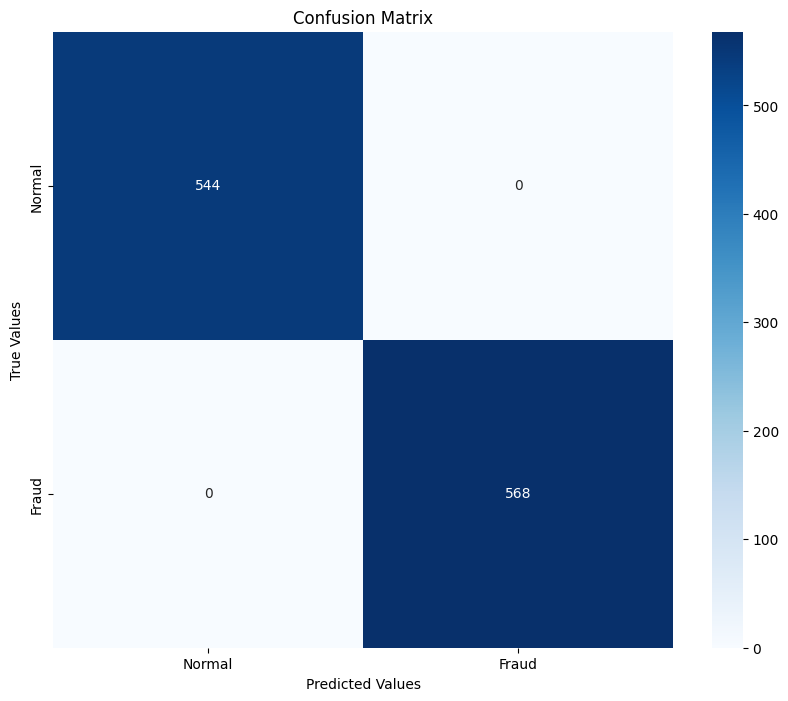

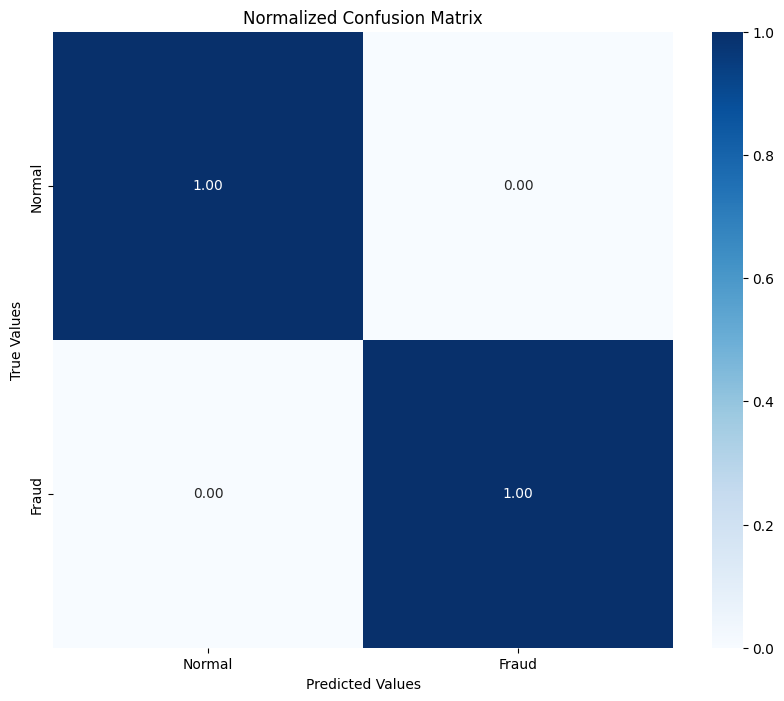

DSC: 1.0, Sensitivity: 1.0, Specificity: 1.0, Accuracy: 1.0


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)

In [2]:
!pip install transformers torch gradio

Ignore receiver message

In [5]:
import gradio as gr
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load model function
def load_model(model_path="best_bert_model.pt"):
    config = BertConfig.from_pretrained("bert-base-uncased")
    config.num_hidden_layers = 6  # Ensure architecture matches trained model
    config.num_labels = 1  # Binary classification
    model = BertForSequenceClassification(config)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load model
model = load_model()

# Function to classify caller messages
def classify_caller_message(caller_messages, scam_detected=False):
    """
    Classifies the latest caller message while considering past caller messages only.
    """
    scam_threshold = 0.7 if scam_detected else 0.5  # Increase scam threshold after a scam is found

    if not caller_messages:
        return "No caller messages to analyze.", scam_detected

    # Format conversation history (only caller messages)
    input_text = " ".join([f"Caller: {text}" for text in caller_messages])
    inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probability
    prediction = torch.sigmoid(outputs.logits).item()

    # Determine scam classification
    is_scam = prediction > scam_threshold
    response = "🚨 Scam Alert: This message might be a scam!" if is_scam else "✅ Caller message seems safe."

    return response, is_scam  # Return classification & scam detection flag

# Gradio Chat Interface
def chat_interface(speaker, message, conversation_log=[], caller_messages=[], scam_detected=False):
    """
    Handles the chat flow while ensuring only the caller's messages affect scam classification.
    """
    conversation_log.append((speaker, message))  # Append to full log

    if speaker == "caller":
        caller_messages.append(message)  # Only keep caller messages for classification
        response, scam_detected = classify_caller_message(caller_messages, scam_detected)
        conversation_log.append(("System", response))
    else:
        response = "✅ Receiver message recorded (ignored for scam detection)."  # Receiver messages do not affect model
        conversation_log.append(("System", response))

    return conversation_log, caller_messages, scam_detected, ""  # Updated states & reset input

# Create Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Conversation Log")
    speaker = gr.Dropdown(["caller", "receiver"], label="Speaker")
    msg = gr.Textbox(placeholder="Enter message...")
    clear = gr.Button("Clear Chat")

    # Maintain separate states
    caller_messages = gr.State([])  # Stores only caller messages
    scam_flag = gr.State(False)  # Tracks scam detection

    msg.submit(chat_interface, [speaker, msg, chatbot, caller_messages, scam_flag],
               [chatbot, caller_messages, scam_flag, msg])

    clear.click(lambda: ([], [], False, ""), outputs=[chatbot, caller_messages, scam_flag, msg])

# Launch Gradio App
demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-5-4409492b4272>:71: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation Log")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://35d055ba30e6885226.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
